<a href="https://colab.research.google.com/github/MatiasMoreno707/lab11-lp/blob/main/lab11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### a. Realice el preprocesamiento de la información que incluya el análisis de datos faltantes, tratamiento de outliers a nivel univariado y multivariado y escalamiento de datos para las variables numéricas

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from scipy.spatial.distance import mahalanobis

In [ ]:
df = pd.read_csv('/content/Advertising-1.csv')
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [ ]:
df.dtypes

,0
TV,float64
Radio,float64
Newspaper,float64
Sales,float64


In [ ]:
df.shape

(200, 4)

In [ ]:
df.isnull().sum()

,0
TV,0
Radio,0
Newspaper,0
Sales,0


In [ ]:
# Outliers univariados (z-score)
from scipy.stats import zscore
z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))
outliers_uni = (z_scores > 3).any(axis=1)

In [ ]:
# Outliers multivariados (Isolation Forest)
iso = IsolationForest(contamination=0.2, random_state=42)
outliers_multi = iso.fit_predict(df.select_dtypes(include=[np.number])) == -1

In [ ]:
# Escalamiento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns='Sales'))

#### b. Cree un algoritmo genético para seleccionar las mejores variables para un modelo de regresión lineal incluyendo diversos valores para los parámetros: tamaño de la población, probabilidad de cruce, probabilidad de mutación y número de generaciones.

In [ ]:
#!pip install deap

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from deap import base, creator, tools, algorithms
import random

In [ ]:
X = df.drop(columns='Sales')
y = df['Sales']

In [ ]:
def eval_model(individual):
    selected = [i for i, bit in enumerate(individual) if bit == 1]
    if not selected:
        return 0.0,
    X_sel = X.iloc[:, selected]
    X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, random_state=42)
    model = LinearRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred),

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [ ]:
toolbox = base.Toolbox()
toolbox.register("attr_bool", lambda: random.randint(0, 1))
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [ ]:
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("evaluate", eval_model)

In [ ]:
pop = toolbox.population(n=20)
hof = tools.HallOfFame(1)
logbook = tools.Logbook()

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.6, mutpb=0.2, ngen=30,
                               stats=stats, halloffame=hof, verbose=False)

In [ ]:
# Guardar evolución de R2
r2_evolution = [gen['max'] for gen in log]


#### c. Realice un gráfico de la evolución del coeficiente de determinación (R2), seleccione las mejores variables, cree un modelo de regresión lineal con base a estas tomando un 80% de datos para el entrenamiento y mida su desempeño con el R2.

In [ ]:
import matplotlib.pyplot as plt


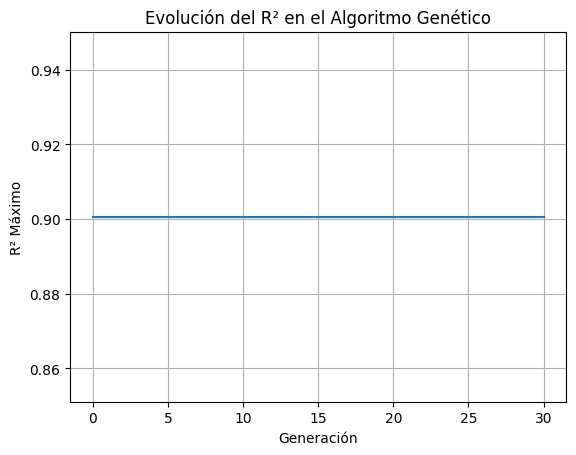

In [ ]:
# Evolución R²
plt.plot(r2_evolution)
plt.xlabel("Generación")
plt.ylabel("R² Máximo")
plt.title("Evolución del R² en el Algoritmo Genético")
plt.grid(True)
plt.show()


In [ ]:
# Seleccionar mejores variables
best_features = [i for i, bit in enumerate(hof[0]) if bit == 1]
selected_columns = X.columns[best_features]
print("Mejores variables:", list(selected_columns))

Mejores variables: ['TV', 'Radio']


In [ ]:

# Modelo final con 80% entrenamiento
X_final = X[selected_columns]
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)
model_final = LinearRegression().fit(X_train, y_train)
r2_final = model_final.score(X_test, y_test)
print("R² del modelo final:", round(r2_final, 4))

R² del modelo final: 0.9006
